<a href="https://colab.research.google.com/github/nwon24/nlp/blob/main/W6/LSTM_WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (50, 172, 300)         │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (50, 172, 20)          │        25,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (50, 3440)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (50, 1)                │         3,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,029,121 (23.00 MB)

 Trainable params: 6,029,121 (23.00 MB)

 Non-trainable params: 0 (0.00 B)

cost: 0.692908, accuracy: 0.520000  [   50/40000]
cost: 0.716790, accuracy: 0.420000  [  550/40000]
cost: 0.697557, accuracy: 0.500000  [ 1050/40000]
cost: 0.691767, accuracy: 0.580000  [ 1550/40000]
cost: 0.678158, accuracy: 0.600000  [ 2050/40000]
cost: 0.640127, accuracy: 0.680000  [ 2550/40000]
cost: 0.628641, accuracy: 0.660000  [ 3050/40000]
cost: 0.596900, accuracy: 0.700000  [ 3550/40000]
cost: 0.588672, accuracy: 0.680000  [ 4050/40000]
cost: 0.515264, accuracy: 0.720000  [ 4550/40000]
cost: 0.453276, accuracy: 0.820000  [ 5050/40000]
cost: 0.520613, accuracy: 0.740000  [ 5550/40000]
cost: 0.427342, accuracy: 0.800000  [ 6050/40000]
cost: 0.454452, accuracy: 0.780000  [ 6550/40000]
cost: 0.394650, accuracy: 0.840000  [ 7050/40000]
cost: 0.472946, accuracy: 0.820000  [ 7550/40000]
cost: 0.421202, accuracy: 0.820000  [ 8050/40000]
cost: 0.433050, accuracy: 0.760000  [ 8550/40000]
cost: 0.454461, accuracy: 0.800000  [ 9050/40000]
cost: 0.435401, accuracy: 0.820000  [ 9550/40000]


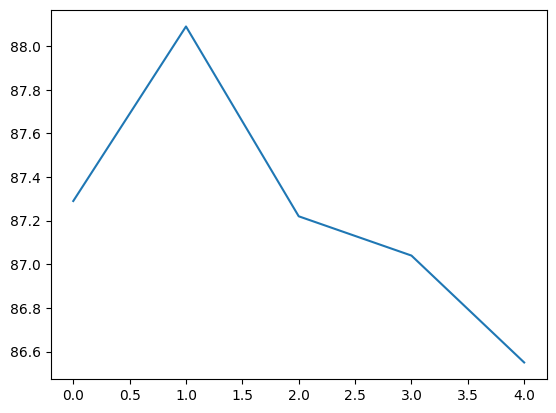

Final accuracy: 86.55, best accuracy: 88.09


In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import InputLayer
from keras.layers import Embedding
from keras.preprocessing import sequence
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn import model_selection
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt


device=torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

data=pd.read_csv("xaa",encoding="utf-8")

word2vec_model = KeyedVectors.load_word2vec_format("drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=20000)
#print(word2vec_model.get_index("the"))
vect  = CountVectorizer(stop_words="english",max_df=0.7)
#corpus = vect.fit_transform(data["text"])
#train_corpus, test_corpus, train_label, test_label = model_selection.train_test_split(data["text"],data["label"],test_size=0.4)
#Encoder = LabelEncoder()
#train_label = Encoder.fit_transform(train_label)
#test_label = Encoder.fit_transform(test_label)
#train_corpus_vect=vect.transform(train_corpus)
#test_corpus_vect=vect.transform(test_corpus)

# Initalise vect.vocabulary_
vect.fit_transform(data["text"])

maxlen=0

def transform(text,vect):
    global maxlen
    global word2vec_model
    #d=vect.vocabulary_
    d=word2vec_model
    p=vect.build_preprocessor()
    t=vect.build_tokenizer()
    vec_list=[]
    for doc in text:
        tokens=t(p(doc))
        doc_vec=np.array([d.get_index(token) for token in tokens if token in d])
        s=len(doc_vec)
        if s>maxlen:
            maxlen=s
        #doc_vec=sequence.pad_sequences(doc_vec,maxlen=maxlen)
        vec_list.append(doc_vec)
    vec_list=sequence.pad_sequences(vec_list,maxlen=maxlen,padding="post")
    corpus_vec=np.vstack(vec_list)
    #return nn.functional.normalize(torch.tensor(corpus_vec).float())
    return torch.tensor(corpus_vec)
    #return torch.tensor(corpus_vec).float()

# print(corpus_vec)

bsize=50
epochs=5
lr=5e-4
embed_dim=300

class corpus(Dataset):
    def __init__(self,corpus,label,seq):
        self.corpus=corpus
        self.label=label
        self.seq=seq
    def __len__(self):
        return len(self.corpus)
    def __getitem__(self,idx):
        return self.corpus[idx],self.label[idx]

class lstm(nn.Module):
    def __init__(self,input_size,hidden_size,seq):
        super(lstm,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.seq=seq
        self.rnn=True
        self.lstm=nn.LSTM(input_size,hidden_size,batch_first=True,num_layers=2)
        self.fc=nn.Linear(self.hidden_size*seq,1)
        #self.fc=nn.Linear(self.hidden_size,1)
        #self.embed=nn.Embedding(len(vect.vocabulary_),input_size)
        self.embed=nn.Embedding.from_pretrained(torch.from_numpy(word2vec_model.vectors),freeze=False)

    def forward(self,x,h0=None,c0=None):
        x=self.embed(x)
        if h0==None and c0==None:
            x, (hn,cn) = self.lstm(x)
        else:
            x, (hn,cn) = self.lstm(x,(h0,c0))
        #print(x[:,-1,:].shape)
        #x = torch.flatten(x[:,-1,:],1)
        # Flatten like this so that all information from previous time steps is fed into fully connected layer
        x=torch.flatten(x,1)
        x = self.fc(x)
        return nn.Sigmoid()(x), hn,cn
        #return nn.Softmax()(x), hn,cn

class dense(nn.Module):
    def __init__(self,seq,vocab,embed_dim):
        super(dense,self).__init__()
        self.seq=seq
        self.rnn=False
        self.network=nn.Sequential(
            nn.Linear(embed_dim*seq,360),
            nn.ReLU(),
            nn.Linear(360,180),
            nn.ReLU(),
            nn.Linear(180,1),
            nn.Sigmoid()
        )
        self.embed=nn.Embedding(vocab,embed_dim)

    def forward(self,x):
        #print(x.shape)
        x=self.embed(x)
        x=torch.flatten(x,1)
        #x=torch.transpose(x,1,2)
        #x=torch.flatten(x,1)
        return self.network(x)

vocab=len(vect.vocabulary_)
Encoder = LabelEncoder()
corpus_vec = transform(data["text"],vect)
train_corpus_vec, test_corpus_vec, train_label, test_label = model_selection.train_test_split(corpus_vec,data["label"],test_size=0.2)
train_label = torch.from_numpy(Encoder.fit_transform(train_label)).float()
test_label = torch.from_numpy(Encoder.fit_transform(test_label)).float()
#train_corpus_vec = transform(train_corpus,vect)
#test_corpus_vec = transform(test_corpus,vect)
lstm_classifier=lstm(embed_dim,200,maxlen)
loss_fn=nn.BCELoss()
#loss_fn=nn.BCEWithLogitsLoss()
#loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(lstm_classifier.parameters(),lr=lr)
#optimizer=torch.optim.SGD(lstm_classifier.parameters(),lr=lr)
#print(len(lstm_classifier(torch.reshape(train_corpus_vec[0],(bsize,maxlen,1)))))

dense_classifier=dense(maxlen,vocab,16)

c=lstm_classifier

c=c.to(device)

train_dataloader=DataLoader(corpus(train_corpus_vec,train_label,maxlen),batch_size=bsize,shuffle=True)
test_dataloader=DataLoader(corpus(test_corpus_vec,test_label,maxlen),batch_size=bsize,shuffle=True)

def train(dataloader,model,loss_fn,optimizer):
    hn,cn=None,None
    size=len(dataloader.dataset)
    model.train()
    for batch,(x,y) in enumerate(dataloader):
        x,y=x.to(device),y.to(device)
        #print(torch.sum(x[0]!=0))
        if model.rnn==True:
            #pred,hn,cn=model(x.reshape(bsize,dataloader.dataset.seq,1).to(device),hn,cn)
            pred,hn,cn=model(x,hn,cn)
        else:
            pred=model(x)
        #pred=model(x)
        cost=loss_fn(pred.flatten(),y)
        cost.backward()
        #if model.rnn==True:
        #    print(model.lstm.weight_ih_l0.grad[0][0])
        optimizer.step()
        optimizer.zero_grad()

        if model.rnn==True:
            hn=hn.detach()
            cn=cn.detach()
        if batch % 10 == 0:
            cost_val, current = cost.item(), batch * bsize + len(x)
            print(f"cost: {cost_val:>7f}, accuracy: {(torch.round(pred.flatten())==y).sum().item()/bsize:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x,y=x.to(device),y.to(device)
            if model.rnn==True:
                #pred,_,_=model(x.reshape(bsize,dataloader.dataset.seq,1).to(device))
                pred,_,_=model(x)
            else:
                pred=model(x)
            #pred=model(x)
            #print(torch.round(pred.flatten()),y)
            test_loss += loss_fn(pred.flatten(), y).item()
            ncorrect = (torch.round(pred.flatten()) == y).sum().item()
            #print(ncorrect)
            correct += ncorrect

    #print(correct,size)
    #print(f"Test Error: \n Accuracy: {(100*correct/size):>0.1f}%, Avg loss: {100*test_loss/size:>8f} \n")
    return 100*correct/size

#keras_model=Sequential([InputLayer(input_shape=(maxlen,),batch_size=bsize),
#                        Embedding(len(vect.vocabulary_),16),
#                  Flatten(),
#                  Dense(1,activation="sigmoid")])
keras_model=Sequential([InputLayer(shape=(maxlen,),batch_size=bsize),
                        Embedding(len(word2vec_model),embed_dim),
                        LSTM(20,return_sequences=True),
                  Flatten(),
                  Dense(1,activation="sigmoid")])
keras_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
keras_model.summary()

use_torch=True

x=np.arange(epochs)
y=np.zeros(epochs)
#print(corpus_vec[0])
if use_torch==True:
    for epoch in range(epochs):
        train(train_dataloader,c,loss_fn,optimizer)
        y[epoch] = test_loop(test_dataloader,c,loss_fn)
    plt.plot(x,y)
    plt.show()
    print(f"Final accuracy: {y[-1]:.2f}, best accuracy: {y[np.argmax(y)]:.2f}")
else:
    keras_model.fit(train_corpus_vec,train_label,batch_size=bsize,epochs=epochs,validation_data=(test_corpus_vec,test_label))
    keras_model.evaluate(test_corpus_vec,test_label,batch_size=bsize)

In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompati

In [ ]:
print(word2vec_model.key_to_index)
print(word2vec_model.vectors)

{'</s>': 0, 'in': 1, 'for': 2, 'that': 3, 'is': 4, 'on': 5, '##': 6, 'The': 7, 'with': 8, 'said': 9, 'was': 10, 'the': 11, 'at': 12, 'not': 13, 'as': 14, 'it': 15, 'be': 16, 'from': 17, 'by': 18, 'are': 19, 'I': 20, 'have': 21, 'he': 22, 'will': 23, 'has': 24, '####': 25, 'his': 26, 'an': 27, 'this': 28, 'or': 29, 'their': 30, 'who': 31, 'they': 32, 'but': 33, '$': 34, 'had': 35, 'year': 36, 'were': 37, 'we': 38, 'more': 39, '###': 40, 'up': 41, 'been': 42, 'you': 43, 'its': 44, 'one': 45, 'about': 46, 'would': 47, 'which': 48, 'out': 49, 'can': 50, 'It': 51, 'all': 52, 'also': 53, 'two': 54, 'after': 55, 'first': 56, 'He': 57, 'do': 58, 'time': 59, 'than': 60, 'when': 61, 'We': 62, 'over': 63, 'last': 64, 'new': 65, 'other': 66, 'her': 67, 'people': 68, 'into': 69, 'In': 70, 'our': 71, 'there': 72, 'A': 73, 'she': 74, 'could': 75, 'just': 76, 'years': 77, 'some': 78, 'U.S.': 79, 'three': 80, 'million': 81, 'them': 82, 'what': 83, 'But': 84, 'so': 85, 'no': 86, 'like': 87, 'if': 88, 'o